# Convert Atlas dataset into Oceantide format

In [7]:
import itertools
import warnings
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import cmocean
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm, colors

from oceantide import read_otis_atlas_netcdf, read_oceantide

warnings.filterwarnings("ignore", category=RuntimeWarning) 


In [8]:
def chunked_iterable(iterable, size):
    """Iterate through array over chunks with specific size."""
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, size))
        if not chunk:
            break
        yield chunk

## Convert by iterating through longitudes over chunks of size 200 to handle memory
The Atlas dataset is very large. It is composed by one file per constituent for elevation and transports at 1/30 degree resolution. Reading in the full dataset into oceantide format cannot be handled unless available RAM is very large. Here we overcome this limitation by converting and concatenating longitude chunks at a time. 

In [3]:
atlas_path = Path("/data/tide/tpxo9v4_atlas/TPXO9_atlas_nc")

lons = xr.open_dataset(atlas_path / "grid_tpxo9_atlas_v4.nc").lon_z.values

chunksizes = 100
itersize = 200

for ind in chunked_iterable(range(lons.size), size=itersize):
    x0 = lons[ind[0]]
    x1 = lons[ind[-1]]
    print(f"Writing lon chunk {ind[0]}")
    dset = read_otis_atlas_netcdf(atlas_path, x0=x0, x1=x1, nxchunk=itersize, nychunk=None)
    dset = dset.chunk({"con": None, "lon": chunksizes, "lat": chunksizes})
    if ind[0] == 0:
        mode = "w"
        append_dim = None
    else:
        mode = "a"
        append_dim = "lon"
    dset.to_zarr("./atlas.zarr", mode=mode, consolidated=True, append_dim=append_dim)


Writing lon chunk 0
Writing lon chunk 200
Writing lon chunk 400
Writing lon chunk 600
Writing lon chunk 800
Writing lon chunk 1000
Writing lon chunk 1200
Writing lon chunk 1400
Writing lon chunk 1600
Writing lon chunk 1800
Writing lon chunk 2000
Writing lon chunk 2200
Writing lon chunk 2400
Writing lon chunk 2600
Writing lon chunk 2800
Writing lon chunk 3000
Writing lon chunk 3200
Writing lon chunk 3400
Writing lon chunk 3600
Writing lon chunk 3800
Writing lon chunk 4000
Writing lon chunk 4200
Writing lon chunk 4400
Writing lon chunk 4600
Writing lon chunk 4800
Writing lon chunk 5000
Writing lon chunk 5200
Writing lon chunk 5400
Writing lon chunk 5600
Writing lon chunk 5800
Writing lon chunk 6000
Writing lon chunk 6200
Writing lon chunk 6400
Writing lon chunk 6600
Writing lon chunk 6800
Writing lon chunk 7000
Writing lon chunk 7200
Writing lon chunk 7400
Writing lon chunk 7600
Writing lon chunk 7800
Writing lon chunk 8000
Writing lon chunk 8200
Writing lon chunk 8400
Writing lon chunk 

## Check amplitudes over New Zealand

In [18]:
dset = read_oceantide("./atlas.zarr")
dset = dset.sel(lon=slice(165, 180), lat=slice(-49, -33)).load()
dset

<xarray.Dataset>
Dimensions:  (con: 14, lat: 480, lon: 450)
Coordinates:
  * con      (con) <U4 'M2' 'S2' 'N2' 'K2' 'K1' ... 'MF' 'M4' 'MN4' 'MS4' '2N2'
  * lat      (lat) float64 -48.97 -48.93 -48.9 -48.87 ... -33.07 -33.03 -33.0
  * lon      (lon) float64 165.0 165.1 165.1 165.1 ... 179.9 179.9 180.0 180.0
Data variables:
    dep      (lat, lon) float32 2.655e+03 2.723e+03 ... 2.864e+03 2.853e+03
    h        (con, lat, lon) complex128 (0.547-0.065j) ... (-0.012-0.006j)
    u        (con, lat, lon) complex128 (-0.0001780200900539481-0.00013615165...
    v        (con, lat, lon) complex128 (-0.0002086218114868909-1.58426355618...
Attributes:
    description:  Oceantide tidal constituents

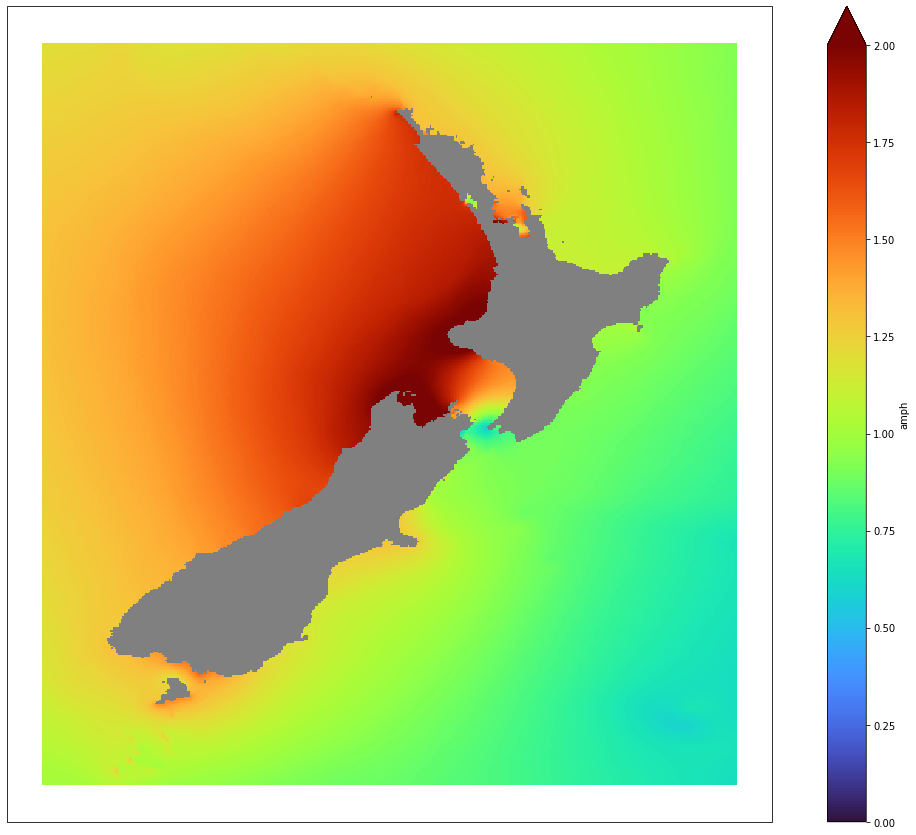

In [23]:
# Tidal elevation amplitude

ds = dset.tide.amplitude("h").sum("con").where(dset.dep > 0)

norm = colors.PowerNorm(gamma=1.0, vmin=0, vmax=2)
cmap = cm.get_cmap("turbo").copy()
cmap.set_bad("0.5")

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
ds.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree());

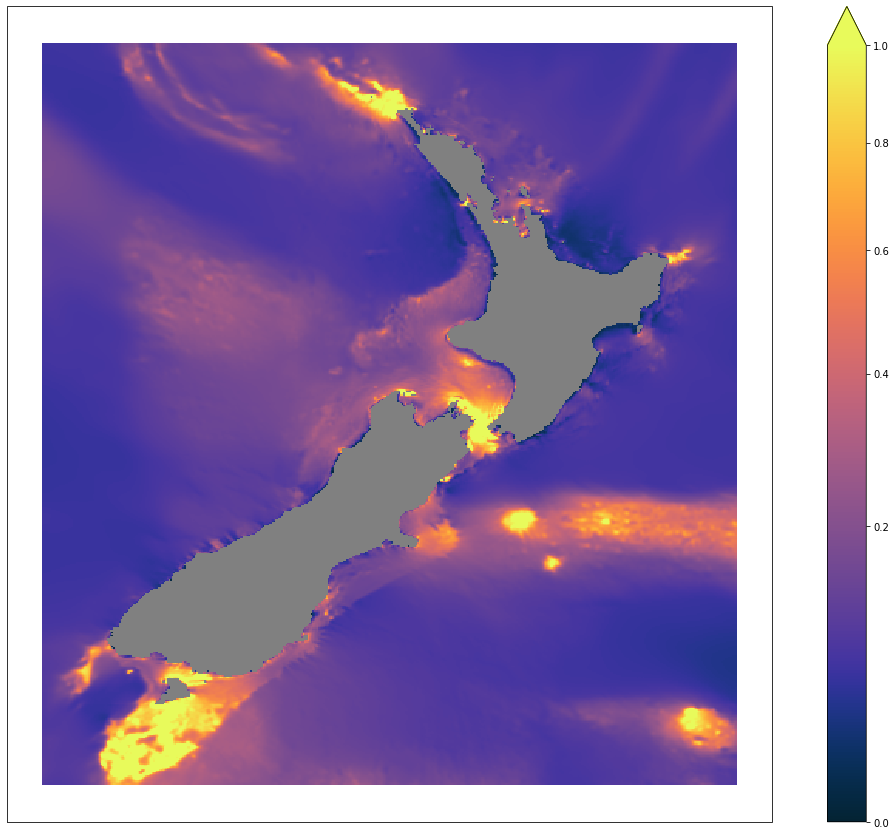

In [22]:
# Tidal current speed amplitude

u = dset.tide.amplitude("u").sum("con")
v = dset.tide.amplitude("v").sum("con")
ds = np.sqrt(u ** 2 + v ** 2).where(dset.dep > 0)

norm = colors.PowerNorm(gamma=0.6, vmin=0, vmax=1)
cmap = cm.get_cmap(cmocean.cm.thermal).copy()
cmap.set_bad("0.5")

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
ds.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree());

## Check amplitudes over Australia

In [24]:
dset = read_oceantide("./atlas.zarr")
dset = dset.sel(lon=slice(110, 156), lat=slice(-46, -7)).load()
dset

<xarray.Dataset>
Dimensions:  (con: 14, lat: 1170, lon: 1380)
Coordinates:
  * con      (con) <U4 'M2' 'S2' 'N2' 'K2' 'K1' ... 'MF' 'M4' 'MN4' 'MS4' '2N2'
  * lat      (lat) float64 -45.97 -45.93 -45.9 -45.87 ... -7.067 -7.033 -7.0
  * lon      (lon) float64 110.0 110.1 110.1 110.1 ... 155.9 155.9 156.0 156.0
Data variables:
    dep      (lat, lon) float32 3.804e+03 3.819e+03 3.834e+03 ... 198.0 5.0
    h        (con, lat, lon) complex128 (-0.105-0.006j) ... (0.003+0.004j)
    u        (con, lat, lon) complex128 (-0.0002231533632300138-6.66975467827...
    v        (con, lat, lon) complex128 (4.7755616049642796e-05+1.23373944649...
Attributes:
    description:  Oceantide tidal constituents

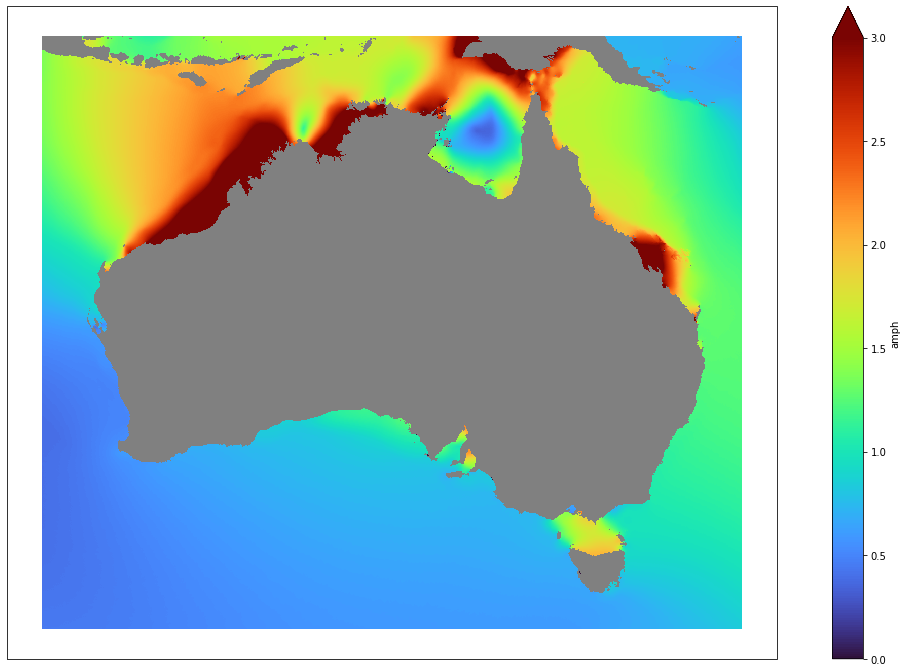

In [26]:
# Tidal elevation amplitude

ds = dset.tide.amplitude("h").sum("con").where(dset.dep > 0)

norm = colors.PowerNorm(gamma=1.0, vmin=0, vmax=3)
cmap = cm.get_cmap("turbo").copy()
cmap.set_bad("0.5")

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
ds.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree());

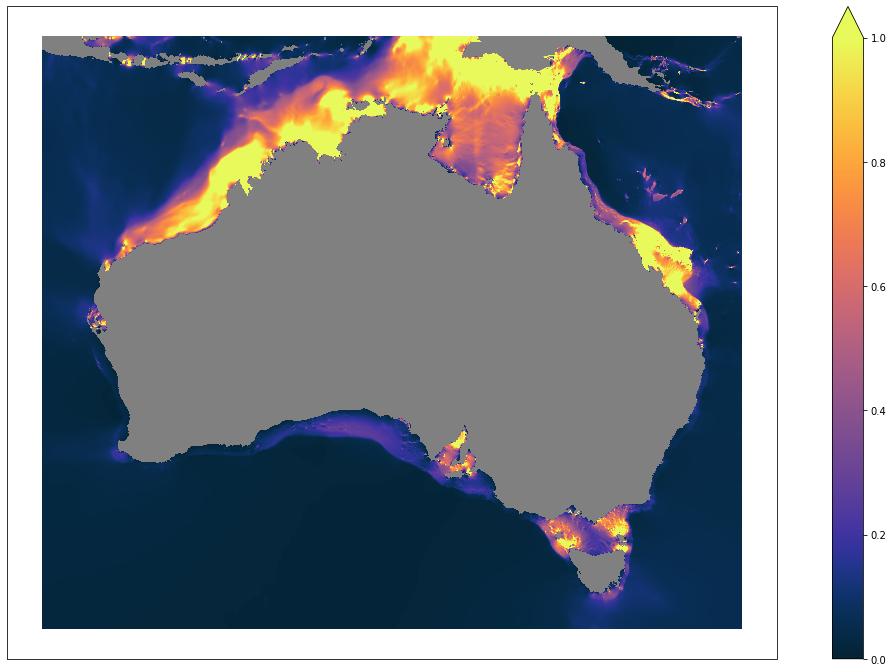

In [27]:
# Tidal current speed amplitude

u = dset.tide.amplitude("u").sum("con")
v = dset.tide.amplitude("v").sum("con")
ds = np.sqrt(u ** 2 + v ** 2).where(dset.dep > 0)

norm = colors.PowerNorm(gamma=1.0, vmin=0, vmax=1)
cmap = cm.get_cmap(cmocean.cm.thermal).copy()
cmap.set_bad("0.5")

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
ds.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree());